In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
#from scipy.stats import gmean

import cvxpy as cp


%matplotlib inline

In [3]:
def calc_sharpe(m):
    '''Calculates Basic Max Sharpe for N-Asset Portfolio 
        ignores Rf rate
    
        array m must be nxm where n= returns, m = assets
        
        Constraint:
        sum(wts) = 1
    
    
        Returns tuple:
        ((wts), sharpe)
        
    '''
    m = np.array(m)
    cov = np.cov(m.T) #unbiased covariance, ddof=1
    u = np.mean(m,axis=0).reshape(-1,1)
    ones = np.ones_like(u)

    wtC = np.linalg.inv(cov).dot(u) / ones.T.dot(np.linalg.inv(cov)).dot(u)
    ret = u.T.dot(wtC)
    stdev = np.sqrt(wtC.T.dot(cov).dot(wtC))
    sharpe = ret/stdev


    return wtC,sharpe[0,0]

In [4]:
def cvx_opt(df):
    
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)

    y = cp.Variable(len(cov))
    funct =cp.quad_form(y, cov)
    prob = cp.Problem(cp.Minimize(funct), 
                   [y@u == 1, 
                    y >= 0,
                   ])
    r = prob.solve()
    
    if np.isinf(r):
        x=np.full((len(cov),),1/len(cov)) # equal weight
    else:
        x = y.value/y.value.sum()

    return x

In [5]:
df_feat = pd.read_csv("../data/raw_features.csv",index_col=0,parse_dates=True)
returns = pd.read_csv("../data/raw_response.csv",index_col=0,parse_dates=True)
df_feat.dropna(inplace=True)

In [6]:
start_d = datetime.date(1980,9,1)

In [7]:
returns = returns.loc[start_d:]
df_feat = df_feat.loc[start_d:]

In [8]:
responses = returns.resample('MS').mean()

In [9]:
df_feat_train = df_feat.loc[:'2005',:]
responses_train = responses.loc[:'2005',:]

df_feat_test = df_feat.loc['2006':,:]
responses_test = responses.loc['2006':,:]

In [10]:
print(df_feat_train.shape)
print(responses_train.shape)

print(df_feat_test.shape)
print(responses_test.shape)

(304, 12)
(304, 3)
(168, 12)
(168, 3)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_feat_train)
X_test = scaler.transform(df_feat_test)

In [12]:
neigh = NearestNeighbors(n_neighbors=8)
neigh.fit(X_train)

NearestNeighbors(n_neighbors=8)

In [13]:
#calc weights of best performance measure on historically similar set

d=[]

for i in range(len(X_test)-1):
    dst, nearest = neigh.kneighbors([X_test[i]],return_distance=True)
    mask = returns.index.strftime('%m-%Y').isin(df_feat_train.iloc[nearest[0],:].index.strftime('%m-%Y'))
    f = returns[mask]
    wts = cvx_opt(f) # insert performance measure here , wts, s = calc_sharpe(f.values)
    d.append(wts)
d = np.array(d)

In [14]:
#get performance on test set
rets = []
stds = []
measures = []

wt0 = np.array([.6,.3,.1])

for i in range(len(d)):
    wts = np.asmatrix(d[i]).reshape(3,1)
    next_month = df_feat_test.index[i] + relativedelta(months=1)
    next_month = datetime.datetime.strftime(next_month,'%m-%Y')
    
    ret = np.asmatrix(returns.loc[next_month].mean()).dot(wts)
    std = np.sqrt(wts.T.dot(returns.loc[next_month].cov().values).dot(wts))
    shrp = np.sqrt(252)*ret/std
    
    ret2 = returns.loc[next_month].mean().dot(wt0)
    std2 = np.sqrt(wt0.T.dot(returns.loc[next_month].cov().values).dot(wt0))
    shrp2 = np.sqrt(252)*ret2/std2
    
    
    rets.append((ret[0,0],ret2))
    stds.append((std[0,0],std2))
    measures.append((shrp[0,0],shrp2))
    
    
rets = np.array(rets)
stds = np.array(stds)
measures = np.array(measures)

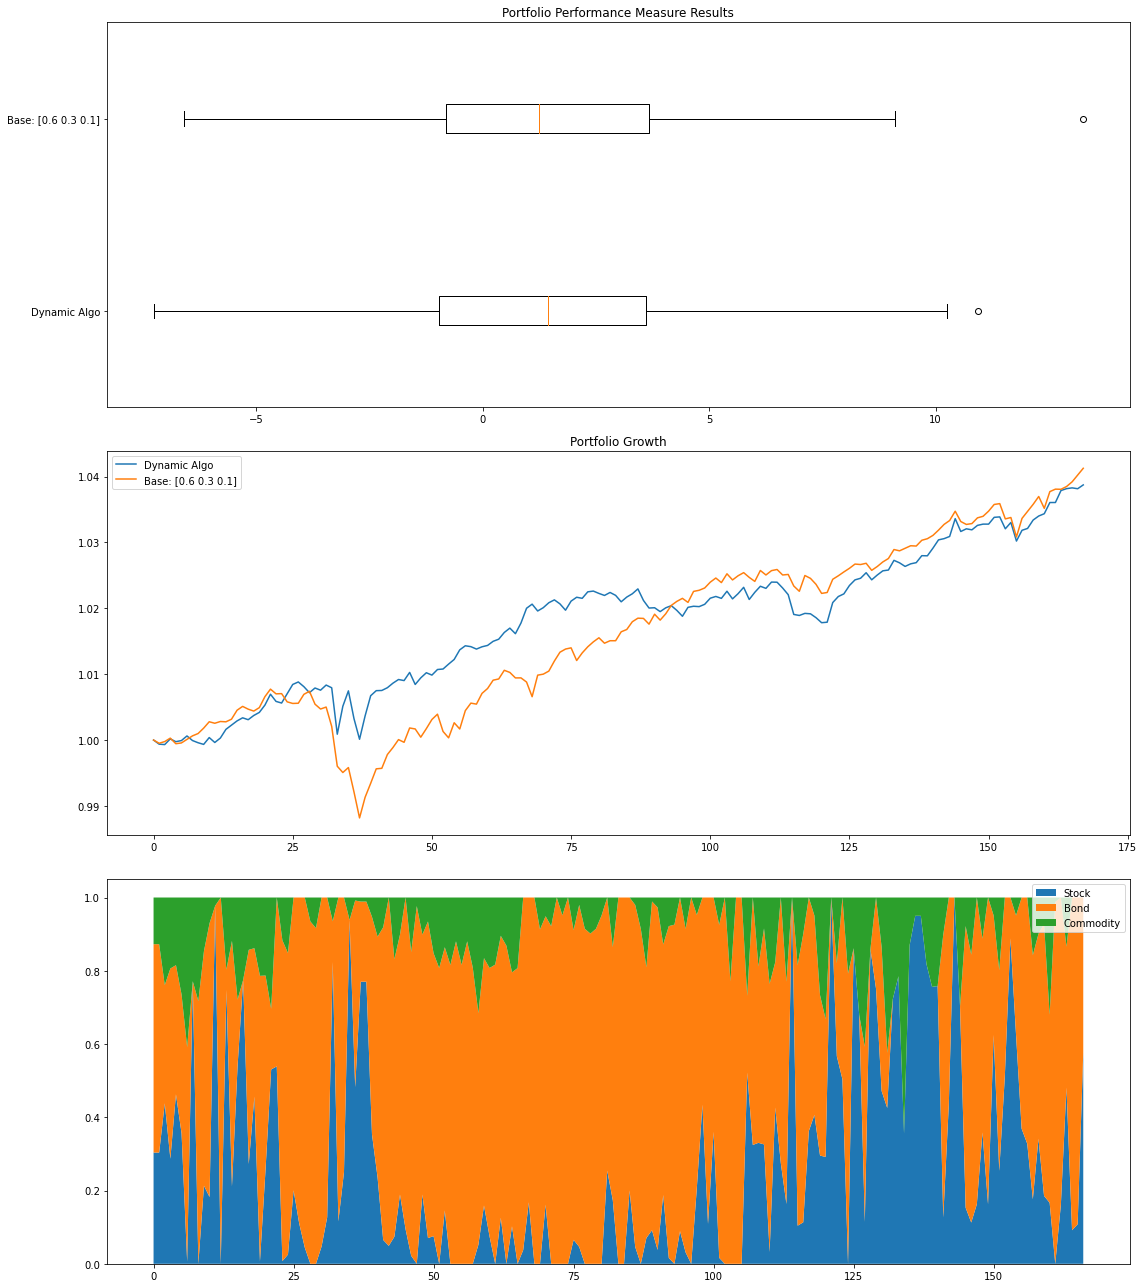

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (16,18))

ax1.boxplot(measures,vert=False,labels=['Dynamic Algo','Base: {}'.format(wt0)])
ax1.set_title('Portfolio Performance Measure Results')

ax2.plot(np.insert((rets+1).cumprod(axis=0),0,1,axis=0))
ax2.set_title('Portfolio Growth')
ax2.legend(labels=['Dynamic Algo','Base: {}'.format(wt0)])

r = np.array(d).reshape(len(d),3)
ax3.stackplot(list(range(len(r))),r.T)
ax3.legend(labels=['Stock','Bond','Commodity'])

fig.tight_layout()

#print((gmean(results[:,0]+1)-1)*252)

In [16]:
np.mean(measures,axis=0)

array([1.37028594, 1.48139174])